# Evaluating initial machine learning performance

I ran the combined Landsat7-and-household-income data through a large-grid ML pipeline, using 30% of the original data as test data, and recording the resulting $R^2$ values. 

### About the grid

The regression models used in this grid search approach are the Linear Regression, Ridge Regression, Linear Support Vector Machine Regression (SVM), Decision Tree Regressor, Bagging Regressor, Gradient Boosting Regressor, and Random Forest Regressor model types. They were selected to provide a range of regression-based approaches. If any major regression-based model seems arbitrarily excluded, it is because I did not understand how they work.

Note: I had originally planned to include Gradient Boosting in the list of models. However, due to the lack of computing hardware available for this step, I was not able to complete a full training run of the Gradient Boosting models on my personal laptop. For the range of models specified in the grid, training Gradient Boosting models alone did not complete within 12 hours over several overnight trials.

For reference, the full range of hyperparameters can be seen in the `GRID_MAIN` variable in [config.py](https://github.com/worldbank/Pakistan-Poverty-from-Sky/blob/ml-first-pass/Code/bisp_approach/03_analysis/config.py).

### About this document

This notebook explores results and feature importances from the various trained models.

1. [Read Results](#1.-Read-results)
2. Explore best-performing models
    - [2.1 Models trained across any feature set](#2.1-Models-trained-across-all-feature-sets)
    - [2.2 Models trained on daytime features only](#2.2-Models-with-Daytime-features-only)
    - [2.3 Models trained on all features only](#2.3-Models-trained-on-All-Features-only)

In [62]:
import os
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score
import graphviz

import config as cf

# Display settings
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

## 1. Read results

### Load results file

In [125]:
RESULTS_PATH = os.path.join('output', 'results.csv')
df = pd.read_csv(RESULTS_PATH)
df.shape

(1092, 7)

In [126]:
df.head()

,Unnamed: 0,regressor,params,features,r2,mse,max_err
0,0,Lasso,"{'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'cyclic', 'random_state': 0}",DAY_FEATURES,0.002785,2.832462e+12,3.112745e+07
1,1,Lasso,"{'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'cyclic', 'random_state': 0}",NIGHT_FEATURES,0.000684,2.838430e+12,3.130330e+07
2,2,Lasso,"{'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'cyclic', 'random_state': 0}",ALL_FEATURES,0.002788,2.832455e+12,3.111432e+07
3,3,Lasso,"{'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'random', 'random_state': 0}",DAY_FEATURES,0.002978,2.831916e+12,3.112967e+07
4,4,Lasso,"{'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'random', 'random_state': 0}",NIGHT_FEATURES,0.000684,2.838430e+12,3.130330e+07


In [127]:
df['regressor'].unique()

array(['Lasso', 'DecisionTreeRegressor', 'LinearSVR', 'Ridge',
       'LinearRegression', 'RandomForestRegressor', 'BaggingRegressor'],
      dtype=object)

## 2. Explore best-performing models

### 2.1 Models trained across all feature sets

First, we take a look at which models performed best for any feature set.

In [4]:
df.sort_values(by='r2', ascending=False).head()

,Unnamed: 0,regressor,params,features,r2,mse,max_err
190,190,DecisionTreeRegressor,"{'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",NIGHT_FEATURES,0.695971,8.635571e+11,20061798.0
118,118,DecisionTreeRegressor,"{'criterion': 'mse', 'splitter': 'best', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",NIGHT_FEATURES,0.695971,8.635571e+11,20061798.0
121,121,DecisionTreeRegressor,"{'criterion': 'mse', 'splitter': 'best', 'max_depth': 20, 'max_features': 'log2', 'random_state': 0}",NIGHT_FEATURES,0.695971,8.635571e+11,20061798.0
193,193,DecisionTreeRegressor,"{'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 20, 'max_features': 'log2', 'random_state': 0}",NIGHT_FEATURES,0.695971,8.635571e+11,20061798.0
225,225,DecisionTreeRegressor,"{'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",DAY_FEATURES,0.680805,9.066333e+11,20061798.0


The best-performing models (by $R^2$) were decision tree regression models trained on night-time features.

Hyperparameters for the best-performing models involved:
- a maximum tree depth of 20 (`max_depth = 20`) 
- searching sqrt(n) or log2(n) features at each split (`max_features = {sqrt, log2}`)
- using mean squared error to determine best non-random splits (`criterion = {mse, friedman_mse}`)

In [5]:
# What was the best performance for each model type?
df.groupby('regressor')['r2'].max().sort_values(ascending=False)

regressor
DecisionTreeRegressor    0.695971
BaggingRegressor         0.635201
RandomForestRegressor    0.554162
LinearRegression         0.003086
Lasso                    0.003085
Ridge                    0.002697
LinearSVR                0.000802
Name: r2, dtype: float64

Only bagging, decision tree, and random forest models achieved $R^2$ scores appreciably above 0. 

Surprisingly, decision trees seem to outperform random forests here. Given how random forests work, this suggests that the problem lies either with bootstrapping features (i.e. useful information is spread across all features such that that we lose info by using subsets) or bootstrapping observations (i.e. our initial dataset is too small for subsets to be useful). 

### 2.1.1 Get feature importances

To re-create feature importances, we'll have to re-train the best-performing models.

In [6]:
# Load final model data
CLEAN_DATA_PATH = os.path.join('output', 'final_data.pkl')
with open(CLEAN_DATA_PATH, 'rb') as f:
    x_train, x_test, y_train, y_test = pickle.load(f)
    
# Verify
for i in (x_train, x_test, y_train, y_test):
    print(i.shape)

(3412, 32)
(1463, 32)
(3412,)
(1463,)


In [7]:
# Verify feature set
features = cf.NIGHT_FEATURES
features

['dmspols_2011', 'viirs_2012', 'dmspols_2011_imputed', 'viirs_2012_imputed']

In [8]:
# Get parameters 
params = eval(df.sort_values(by='r2', ascending=False).reset_index().iloc[0]['params'])
params

{'criterion': 'friedman_mse',
 'splitter': 'best',
 'max_depth': 20,
 'max_features': 'sqrt',
 'random_state': 0}

In [9]:
# Retrain best tree
dt = DecisionTreeRegressor(**params)
dt.fit(x_train[features], y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=20,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=0, splitter='best')

In [10]:
# Verify this is the model with the highest R2
pred_labels = dt.predict(x_test[features])

r2_score(y_true=y_test, y_pred=pred_labels)

-0.4502273446300675

In [11]:
importance = pd.DataFrame({'feature': features, 'importance': dt.feature_importances_})
importance

,feature,importance
0,dmspols_2011,0.104068
1,viirs_2012,0.895772
2,dmspols_2011_imputed,0.000160
3,viirs_2012_imputed,0.000000


Unsurprisingly, `viirs_2012` seems to be the most important feature in this model.

### 2.1.2 Visualize tree

Final decision tree (with max depth 20) is a little too large to display here.

In [12]:
# export_graphviz(dt,
#                 out_file=os.path.join('output', 'tree.dot'),
#                 feature_names=cf.NIGHT_FEATURES,
#                 filled=True)

# graphviz.Source.from_file(os.path.join('output', 'tree.dot'))

### 2.2 Models with Daytime features only

What about models trained on daytime features? Which ones performed best? Which were the most important features?

In [13]:
df.loc[df['features'] == 'DAY_FEATURES'] \
    .sort_values(by='r2', ascending=False) \
    .head()

,Unnamed: 0,regressor,params,features,r2,mse,max_err
225,225,DecisionTreeRegressor,"{'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",DAY_FEATURES,0.680805,9.066333e+11,2.006180e+07
153,153,DecisionTreeRegressor,"{'criterion': 'mse', 'splitter': 'random', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",DAY_FEATURES,0.680805,9.066333e+11,2.006180e+07
189,189,DecisionTreeRegressor,"{'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",DAY_FEATURES,0.656971,9.743306e+11,2.003678e+07
117,117,DecisionTreeRegressor,"{'criterion': 'mse', 'splitter': 'best', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",DAY_FEATURES,0.656971,9.743306e+11,2.003678e+07
1083,1083,BaggingRegressor,"{'n_estimators': 10000, 'max_features': 0.3, 'random_state': 0, 'n_jobs': -1}",DAY_FEATURES,0.635201,1.036166e+12,1.989730e+07


The best-performing daytime models (by $R^2$) were also decision trees.

Hyperparameters for the best-performing daytime models involved:
- a maximum tree depth of 20 (`max_depth = 20`) 
- searching sqrt(n) features at each split (`max_features = sqrt`)
- with random splits (`splitter = random`)

In [14]:
day_params = eval(df.loc[df['features'] == 'DAY_FEATURES'] \
    .sort_values(by='r2', ascending=False) \
    .reset_index() \
    .iloc[0]['params'])
day_params

{'criterion': 'friedman_mse',
 'splitter': 'random',
 'max_depth': 20,
 'max_features': 'sqrt',
 'random_state': 0}

In [15]:
# Retrain best tree
day_dt = DecisionTreeRegressor(**day_params)
day_dt.fit(x_train[cf.DAY_FEATURES], y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=20,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=0, splitter='random')

In [16]:
# Verify this is the model with the highest R2
day_pred_labels = day_dt.predict(x_test[cf.DAY_FEATURES])

r2_score(y_true=y_test, y_pred=day_pred_labels)

-1.000808666245904

In [17]:
day_importance = pd.DataFrame({'feature': cf.DAY_FEATURES, 'importance': day_dt.feature_importances_})
day_importance.sort_values(by='importance', ascending=False).head()

,feature,importance
1,l7_2011_2,0.253304
27,ratio_6_7,0.144409
23,ratio_4_6,0.114767
4,l7_2011_5,0.074585
16,ratio_2_6,0.052273


In this model, the Landsat Band 2 (blue) seems to be most important, followed by:
- the ratio of Band 6 to Band 7 (SWIR1 and SWIR2)
- then the ratio of Band 4 to Band 6 (Red and SWIR1)
- then Band 5 (NIR)

### 2.3 Models trained on All Features only

What about models trained on all features? How does the feature importance of the daytime features compare to that of the nighttime ones?

In [18]:
df.loc[df['features'] == 'ALL_FEATURES'].sort_values(by=['r2'], ascending=False).head()

,Unnamed: 0,regressor,params,features,r2,mse,max_err
1085,1085,BaggingRegressor,"{'n_estimators': 10000, 'max_features': 0.3, 'random_state': 0, 'n_jobs': -1}",ALL_FEATURES,0.634160,1.039122e+12,1.992488e+07
1067,1067,BaggingRegressor,"{'n_estimators': 100, 'max_features': 0.3, 'random_state': 0, 'n_jobs': -1}",ALL_FEATURES,0.631913,1.045506e+12,1.992133e+07
1076,1076,BaggingRegressor,"{'n_estimators': 1000, 'max_features': 0.3, 'random_state': 0, 'n_jobs': -1}",ALL_FEATURES,0.631641,1.046278e+12,1.993062e+07
1088,1088,BaggingRegressor,"{'n_estimators': 10000, 'max_features': 0.5, 'random_state': 0, 'n_jobs': -1}",ALL_FEATURES,0.623065,1.070636e+12,1.991678e+07
1079,1079,BaggingRegressor,"{'n_estimators': 1000, 'max_features': 0.5, 'random_state': 0, 'n_jobs': -1}",ALL_FEATURES,0.620876,1.076854e+12,1.990345e+07


In [19]:
# Verify feature set
features = cf.ALL_FEATURES
features

['dmspols_2011',
 'viirs_2012',
 'dmspols_2011_imputed',
 'viirs_2012_imputed',
 'l7_2011_1',
 'l7_2011_2',
 'l7_2011_3',
 'l7_2011_4',
 'l7_2011_5',
 'l7_2011_6',
 'l7_2011_7',
 'ratio_1_2',
 'ratio_1_3',
 'ratio_1_4',
 'ratio_1_5',
 'ratio_1_6',
 'ratio_1_7',
 'ratio_2_3',
 'ratio_2_4',
 'ratio_2_5',
 'ratio_2_6',
 'ratio_2_7',
 'ratio_3_4',
 'ratio_3_5',
 'ratio_3_6',
 'ratio_3_7',
 'ratio_4_5',
 'ratio_4_6',
 'ratio_4_7',
 'ratio_5_6',
 'ratio_5_7',
 'ratio_6_7']

In [20]:
# Get parameters 
params = eval(df.iloc[1085]['params'])
params

{'n_estimators': 10000, 'max_features': 0.3, 'random_state': 0, 'n_jobs': -1}

In [21]:
# Retrain best tree
bg = BaggingRegressor(**params)
bg.fit(x_train[features], y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.3, max_samples=1.0, n_estimators=10000,
                 n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                 warm_start=False)

In [22]:
# Verify this is the model with the highest R2
all_pred_labels = bg.predict(x_test[cf.ALL_FEATURES])

r2_score(y_true=y_test, y_pred=all_pred_labels)

-0.07085622857386764

### 2.3.1 Recover feature importances

Our best-performing bagging model used a random sample of 30% (approx 9) of our features in each of its 10,000 estimator. Since each estimator has a different combination of features, I manually implement a feature importance calculation as follows:
1. Assume that every feature not in a given estimator has an importance of 0. This prevents a feature that appears in a low number of estimators but has a high importance from being ranked highly.
2. Recover every feature importance from every estimator and map it back to the feature name. 
3. Calculate the mean importance for each feature.

The BaggingRegressor model uses a DecisionTreeRegressor as its base estimator. With default hyperparameters, it main splitting criterion is on mean squared error (MSE). We can therefore interpret the final importance metric for any given feature as the mean of the total normalized reduction in MSE achieved by splitting on that feature over all nodes of all estimators in the bagging model.

In [41]:
# How many features did each estimator use?
math.floor(0.3 * len(features))

9

In [45]:
# Get feature importances for each estimator, make a dataframe, then append all dataframes together
num_estimators = 10000
fi_list = []
for i in range(num_estimators):
    names = [features[x] for x in bg.estimators_features_[i]]
    importances = bg.estimators_[i].feature_importances_
    df = pd.DataFrame({
        'model_num': i,
        'f_name': names,
        'f_impt': importances
    })
    fi_list.append(df)
    
importances_df = pd.concat(fi_list, ignore_index=True)
importances_df.head()

,model_num,f_name,f_impt
0,0,l7_2011_7,0.112993
1,0,ratio_1_4,0.025539
2,0,l7_2011_5,0.417844
3,0,ratio_3_5,0.165718
4,0,l7_2011_1,0.023277


In [46]:
# Gut check: There should be 10000 estimators * 9 variables = 90000 rows
importances_df.shape

(90000, 3)

In [57]:
# "Expand" importances_df such that features not in each estimator have an importance of 0
all_importances = importances_df.set_index(['model_num', 'f_name']).T.stack().unstack().T \
    .reset_index() \
    .fillna(0)

all_importances.head()

,model_num,f_name,f_impt
0,0,dmspols_2011,0.000000
1,0,dmspols_2011_imputed,0.000000
2,0,l7_2011_1,0.023277
3,0,l7_2011_2,0.029289
4,0,l7_2011_3,0.000000


In [58]:
# Gut check: There should be 10000 estimators * 32 variables = 320000 rows
all_importances.shape

(320000, 3)

In [108]:
# Get mean importance for all features
summary = all_importances.groupby('f_name').mean()['f_impt'] \
    .sort_values(ascending=False)
summary.head()

f_name
ratio_1_3    0.069604
ratio_2_3    0.068389
ratio_6_7    0.056186
ratio_3_7    0.051830
ratio_1_7    0.043753
Name: f_impt, dtype: float64

Looks like the ratio of Band 1 to Band 3 (Blue:Red) as well as the ratio of Band 2 to Band 3 (Green:Red) had the highest feature importances. In other words, splitting on those features in the BaggingRegressor model led to the largest decreases in MSE on average.

In [109]:
# Gut check: how does this compare to the non-expanded importances_df?
importances_df.groupby('f_name').mean()['f_impt'].sort_values(ascending=False).head()

f_name
ratio_1_3    0.249299
ratio_2_3    0.245211
ratio_6_7    0.197211
ratio_3_7    0.186170
ratio_1_7    0.153682
Name: f_impt, dtype: float64

In [112]:
# Gut check: which features appeared in the most estimators?
feature_list = [features[x] for i in range(num_estimators) for x in bg.estimators_features_[i]]
feature_count = pd.Series(feature_list).value_counts().sort_values(ascending=False)
feature_count.head()

l7_2011_4               2924
ratio_1_5               2896
ratio_3_5               2874
dmspols_2011_imputed    2874
ratio_2_5               2862
dtype: int64

Text(0.5, 0, 'Number of estimators that the feature appeared in')

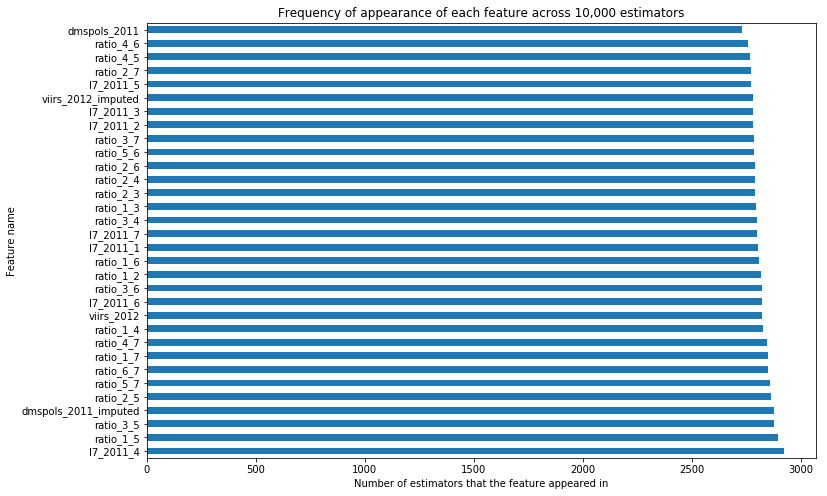

In [123]:
# Plot the feature appearance counts to get a sense of proportions and scale
ax = feature_count.plot.barh(figsize=(12,8),
                        title='Frequency of appearance of each feature across 10,000 estimators')
ax.set_ylabel('Feature name')
ax.set_xlabel('Number of estimators that the feature appeared in')